<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-1/blob/main/hashing_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

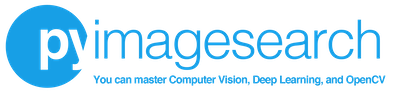

# Building an Image Hashing Search Engine with VP-Trees and OpenCV
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Building an Image Hashing Search Engine with VP-Trees and OpenCV](https://www.pyimagesearch.com/2019/08/26/building-an-image-hashing-search-engine-with-vp-trees-and-opencv/) blog post published on 2019-08-26.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install necessary packages

In [1]:
!pip install opencv-contrib-python
!pip install vptree

### Download the code zip file

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
!unzip -qq hashing-search-engine.zip
%cd hashing-search-engine

--2021-05-25 11:19:35--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.153.64
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.153.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113505 (111K) [application/zip]
Saving to: ‘hashing-search-engine.zip.1’

hashing-search-engi 100%[===================>] 110.84K   446KB/s    in 0.2s    

2021-05-25 11:19:36 (446 KB/s) - ‘hashing-search-engine.zip.1’ saved [113505/113505]

replace hashing-search-engine/index_images.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
/content/hashing-search-engine


Dataset del gobierno de la rioja

In [3]:
!wget https://www.dropbox.com/s/chfwr4x475y3p1v/noticiasFotos.zip?dl=0 -O 2.zip
!unzip 2.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: 2/467124.jpg            
  inflating: 2/467130.jpg            
  inflating: 2/467131.jpg            
  inflating: 2/467132.jpg            
  inflating: 2/467135.jpg            
  inflating: 2/467136.jpg            
  inflating: 2/467138.jpg            
  inflating: 2/467139.jpg            
  inflating: 2/467140.jpg            
  inflating: 2/46715.jpg             
  inflating: 2/467156.jpg            
  inflating: 2/46716.jpg             
  inflating: 2/467161.jpg            
  inflating: 2/467163.jpg            
  inflating: 2/467164.jpg            
  inflating: 2/467169.jpg            
  inflating: 2/46717.jpg             
  inflating: 2/467170.jpg            
  inflating: 2/467173.jpg            
  inflating: 2/453565.jpg            
  inflating: 2/453569.jpg            
  inflating: 2/45357.jpg             
  inflating: 2/453572.jpg            
  inflating: 2/453576.jpg            
  inflating: 2/453577.jpg  

## Blog Post Code

### Import Packages

In [4]:
# import the necessary packages
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import pickle
import vptree
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [5]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our image hashing utilities

In [6]:
def dhash(image, hashSize=8):
	# convert the image to grayscale
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	
	# resize the input image, adding a single column (width) so we
	# can compute the horizontal gradient
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [7]:
def convert_hash(h):
	# convert the hash to NumPy's 64-bit float and then back to
	# Python's built in int
	return int(np.array(h, dtype="float64"))

In [8]:
def hamming(a, b):
	# compute and return the Hamming distance between the integers
	return bin(int(a) ^ int(b)).count("1")

### Implementing our image hash indexer

In [9]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--images", required=True, type=str,
# 	help="path to input directory of images")
# ap.add_argument("-t", "--tree", required=True, type=str,
# 	help="path to output VP-Tree")
# ap.add_argument("-a", "--hashes", required=True, type=str,
# 	help="path to output hashes dictionary")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "images": "2",
    "tree": "vptree.pickle",
    "hashes": "hashes.pickle"
}

In [ ]:
# grab the paths to the input images and initialize the dictionary
# of hashes
imagePaths = list(paths.list_images(args["images"]))
hashes = {}

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the input image
  try:
    print("[INFO] processing image {}/{}".format(i + 1,
      len(imagePaths)))
    image = cv2.imread(imagePath)

    # compute the hash for the image and convert it
    h = dhash(image)
    h = convert_hash(h)

    # update the hashes dictionary
    l = hashes.get(h, [])
    l.append(imagePath)
    hashes[h] = l
  except:
    print('error')

Se han truncado las últimas 5000 líneas del flujo de salida.
error
[INFO] processing image 3536/21678
error
[INFO] processing image 3537/21678
error
[INFO] processing image 3538/21678
error
[INFO] processing image 3539/21678
error
[INFO] processing image 3540/21678
error
[INFO] processing image 3541/21678
error
[INFO] processing image 3542/21678
error
[INFO] processing image 3543/21678
error
[INFO] processing image 3544/21678
error
[INFO] processing image 3545/21678
error
[INFO] processing image 3546/21678
error
[INFO] processing image 3547/21678
error
[INFO] processing image 3548/21678
error
[INFO] processing image 3549/21678
error
[INFO] processing image 3550/21678
error
[INFO] processing image 3551/21678
error
[INFO] processing image 3552/21678
error
[INFO] processing image 3553/21678
error
[INFO] processing image 3554/21678
error
[INFO] processing image 3555/21678
error
[INFO] processing image 3556/21678
error
[INFO] processing image 3557/21678
error
[INFO] processing image 3558/21

In [ ]:
# build the VP-Tree
print("[INFO] building VP-Tree...")
points = list(hashes.keys())
tree = vptree.VPTree(points, hamming)

In [ ]:
# serialize the VP-Tree to disk
print("[INFO] serializing VP-Tree...")
f = open(args["tree"], "wb")
f.write(pickle.dumps(tree))
f.close()

# serialize the hashes to dictionary
print("[INFO] serializing hashes...")
f = open(args["hashes"], "wb")
f.write(pickle.dumps(hashes))
f.close()

### Implementing our image hash searching script

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-t", "--tree", required=True, type=str,
# 	help="path to pre-constructed VP-Tree")
# ap.add_argument("-a", "--hashes", required=True, type=str,
# 	help="path to hashes dictionary")
# ap.add_argument("-q", "--query", required=True, type=str,
# 	help="path to input query image")
# ap.add_argument("-d", "--distance", type=int, default=10,
# 	help="maximum hamming distance")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "tree": "vptree.pickle",
    "hashes": "hashes.pickle",
    "query": "queries/acordion.jpg",
    "distance": 10
}

In [ ]:
# import the necessary packages
from imutils import paths
import argparse
import time
import sys
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
# load the VP-Tree and hashes dictionary
print("[INFO] loading VP-Tree and hashes...")
tree = pickle.loads(open(args["tree"], "rb").read())
hashes = pickle.loads(open(args["hashes"], "rb").read())

# load the input query image
image = cv2.imread('/content/hashing-search-engine/queries/a.jpg')
plt_imshow("Query", image)




# compute the hash for the query image, then convert it
queryHash = dhash(image)
print('HASH:')
print(queryHash)
queryHash = convert_hash(queryHash)

In [ ]:
# perform the search
print("[INFO] performing search...")
start = time.time()
results = tree.get_all_in_range(queryHash, args["distance"])
results = sorted(results)
end = time.time()
print("[INFO] search took {} seconds".format(end - start))

In [ ]:
results

In [ ]:
# loop over the results
for (d, h) in results:
	# grab all image paths in our dataset with the same hash
	resultPaths = hashes.get(h, [])
	print("[INFO] {} total image(s) with d: {}, h: {}".format(
		len(resultPaths), d, h))

	# loop over the result paths
	for resultPath in resultPaths:
		# load the result image and display it to our screen
		result = cv2.imread(resultPath)
		plt_imshow("Result", result)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Building an Image Hashing Search Engine with VP-Trees and OpenCV*](https://www.pyimagesearch.com/2019/08/26/building-an-image-hashing-search-engine-with-vp-trees-and-opencv/) blog post published on 2019-08-26.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```